In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikamal/rock-paper-scissors-dataset")

print("Path to dataset files:", path)

100%|██████████| 452M/452M [00:20<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset,DataLoader,random_split
import torchvision.transforms as tt
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1/Rock-Paper-Scissors'

In [ ]:
rock_test_files = os.listdir( data_dir +'/test/rock')
print("No. of test examples for rock:", len(rock_test_files))
print(rock_test_files[:5])

No. of test examples for rock: 124
['testrock03-04.png', 'testrock01-25.png', 'testrock03-22.png', 'testrock01-13.png', 'testrock03-17.png']


In [ ]:
rock_train_files = os.listdir( data_dir +'/train/rock')
print("No. of train examples for rock:", len(rock_train_files))
print(rock_train_files[:5])

No. of train examples for rock: 840
['rock03-059.png', 'rock01-109.png', 'rock04-022.png', 'rock03-010.png', 'rock07-k03-046.png']


In [ ]:
resize_tensor_tfms = tt.Compose([tt.Resize(32),tt.ToTensor()])
only_tensor_tfms = tt.Compose([tt.ToTensor()])


In [ ]:
from torchvision.datasets import ImageFolder



dataset=ImageFolder(data_dir +'/train',transform=only_tensor_tfms)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1/Rock-Paper-Scissors/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
train_ds,val_ds=random_split(dataset,[2320,200])

In [ ]:
train_ds

In [ ]:
bs=5

train_loader=DataLoader(train_ds,batch_size=bs,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size=bs,shuffle=True,num_workers=4,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for img,label in train_loader:
    print(img)
    break

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 0.9961, 1.0000,  ..., 1

In [ ]:
import matplotlib

In [ ]:
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Label :  paper (0)


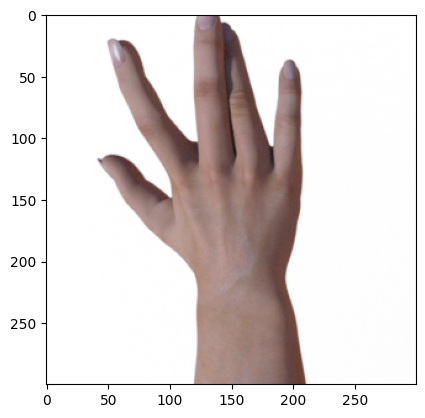

In [ ]:
def show_img(img,label):
    print('Label : ',dataset.classes[label],'('+str(label)+')')
    return plt.imshow(img.permute(1,2,0))

show_img(*dataset[5])

torch.Size([5, 3, 300, 300])


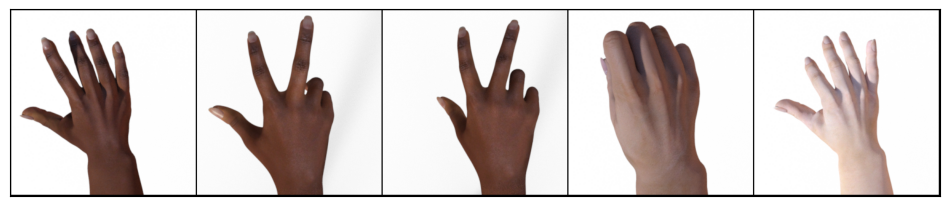

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for img,label in dl:
        print(img.shape)
        fig,ax=plt.subplots(figsize=(12,6))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(img,nrow=16).permute(1,2,0))
        break

show_batch(train_loader)



In [ ]:
class ImageClassificationBase(nn.Module):

    def training_step(self,batch):
        image,label=batch
        out=self(image)
        loss=F.cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        image,label=batch
        out=self(image)
        val_loss=F.cross_entropy(out,label)
        val_acc= self.accuracy(out,label)
        return {'val_loss':val_loss,'val_acc':val_acc}

    def val_epoch_end(self,output):
        batch_loss=[x['val_loss'] for x in output]
        epoch_loss=torch.stack(batch_loss).mean()
        batch_acc=[x['val_acc'] for x in output]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
       print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    @torch.no_grad()
    def evaluate(self,val_loader):
       output=[self.validation_step(batch) for batch in val_loader]
       return self.val_epoch_end(output)

    def accuracy(self,output,label):
       _,pred=torch.max(output,dim=1)
       return torch.tensor(torch.sum(pred==label).item()/len(pred))


In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(256*37*37,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,10)

        )
    def forward(self,xb):
        return self.network(xb)

In [ ]:
32*32

1024

In [ ]:
model=Cifar10CnnModel()

In [ ]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=350464, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():

    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_loader,device)
val_dl=DeviceDataLoader(val_loader,device)
to_device(model,device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=350464, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

In [ ]:
def fit(epochs,lr,model,train_dl,val_dl,opt_f=torch.optim.SGD):

    history=[]
    opt=opt_f(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
        result=model.evaluate(val_dl)
        result['train_loss']=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
model=to_device(Cifar10CnnModel(),device)

In [ ]:
model.evaluate(val_dl)

{'val_loss': 2.3220722675323486, 'val_acc': 0.0}

In [ ]:
num_epoch=10
opt_f=torch.optim.Adam
lr=0.001

history=fit(num_epoch,lr,model,train_dl,val_dl,opt_f)

Epoch [0], train_loss: 1.1513, val_loss: 1.1086, val_acc: 0.3600
Epoch [1], train_loss: 1.1068, val_loss: 1.1118, val_acc: 0.2600
Epoch [2], train_loss: 1.1051, val_loss: 1.0969, val_acc: 0.3800
Epoch [3], train_loss: 1.1038, val_loss: 1.0890, val_acc: 0.3800
Epoch [4], train_loss: 1.1029, val_loss: 1.1052, val_acc: 0.2600
Epoch [5], train_loss: 1.1013, val_loss: 1.0962, val_acc: 0.3600
Epoch [6], train_loss: 1.1010, val_loss: 1.0977, val_acc: 0.3800
Epoch [7], train_loss: 1.1007, val_loss: 1.1005, val_acc: 0.3600
Epoch [8], train_loss: 1.1002, val_loss: 1.1000, val_acc: 0.3800
Epoch [9], train_loss: 1.1001, val_loss: 1.0987, val_acc: 0.3800


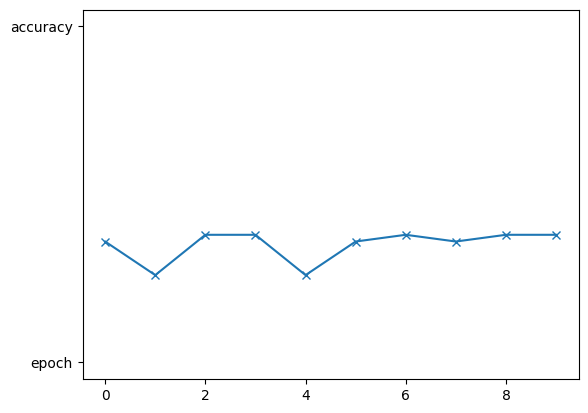

In [ ]:
def plot_accuracies(history):
  accuracies=[x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.plot('epoch')
  plt.plot('accuracy')

plot_accuracies(history)

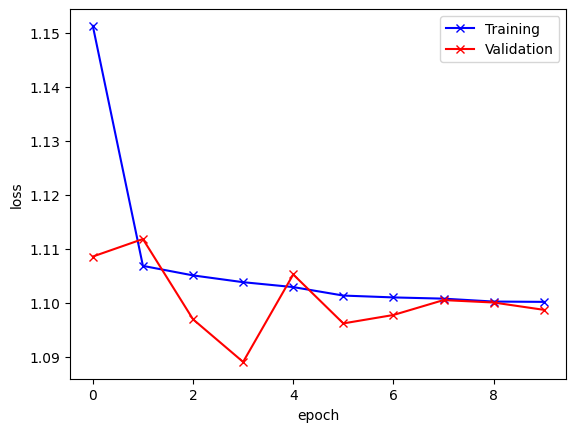

In [ ]:
def plot_losses(history):
  train_losses=[x.get('train_loss') for x in history]
  val_losses=[x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])

plot_losses(history)

In [ ]:
test_data=ImageFolder(data_dir +'/test',transform=only_tensor_tfms)

In [ ]:
def predict_image(img,batch):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)

  _,preds=torch.max(yb,dim=1)
  return dataset.classes[preds[0].item()]

label:  paper predicted : scissors


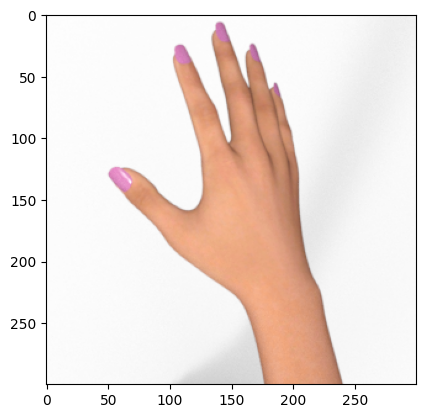

In [ ]:
img,label=test_data[0]
plt.imshow(img.permute(1,2,0))
print('label: ',dataset.classes[label],'predicted :',predict_image(img,model))

label:  rock predicted : scissors


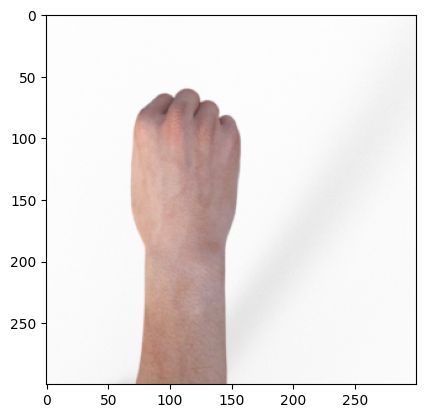

In [ ]:
img,label=test_data[200]
plt.imshow(img.permute(1,2,0))
print('label: ',dataset.classes[label],'predicted :',predict_image(img,model))

label:  paper predicted : scissors


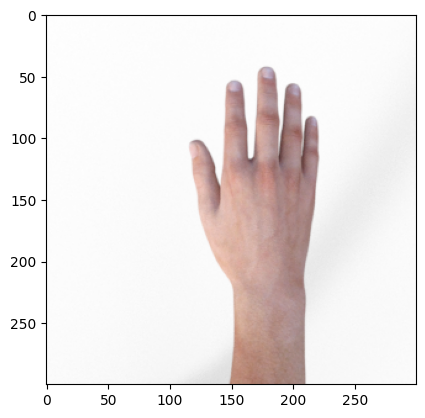

In [ ]:
img,label=test_data[90]
plt.imshow(img.permute(1,2,0))
print('label: ',dataset.classes[label],'predicted :',predict_image(img,model))